# Import Libraries

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [7]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-30.0, 30.0), fill=([1, 1, 1,])),
                                       transforms.ToTensor(),
                                       transforms.Normalize(
                                        (0.4914, 0.4822, 0.4465),
                                        (0.2470, 0.2435, 0.2616)
                                       )
])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize(
                                        (0.4914, 0.4822, 0.4465),
                                        (0.2470, 0.2435, 0.2616)
                                       )
])

# Dataset and Creating Train/Test Split

In [8]:
train_data = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test_data = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

batch_size=128
kwargs = {
    'batch_size': batch_size,
    'shuffle': True,
    'num_workers': 2,
    'pin_memory': True}

train_loader = torch.utils.data.DataLoader(train_data, **kwargs)
kwargs['shuffle']= False
test_loader = torch.utils.data.DataLoader(test_data, **kwargs)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
def get_layer(layer_type, in_channel=None, out_channel=None,
              dropout_value=0.05):
    if layer_type == 'C':
        return nn.Sequential(
            nn.Conv2d(in_channels=in_channel,
                      out_channels=out_channel,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(2, out_channel),
            nn.Dropout(dropout_value)
        )
    elif layer_type == 'c':
        return nn.Conv2d(in_channels=in_channel,
                        out_channels=out_channel,
                        kernel_size=(1, 1), padding=0, bias=False)
    elif layer_type == 'P':
        return nn.MaxPool2d(2, 2)
    elif layer_type == 'G':
        return nn.AdaptiveAvgPool2d(output_size=1)

In [10]:
class Net(nn.Module):
    def __init__(self, schema, channels, dropout_value=0.01):
        super(Net, self).__init__()
        self.layers = nn.ModuleList()
        for layer_type, channel_in, channel_out in zip(
            schema, [3, *channels], channels):
            self.layers.append(get_layer(
                layer_type, channel_in, channel_out,
                dropout_value))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [11]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
# device = torch.device("cuda" if use_cuda else "cpu")
device='mps:0'
print(device)
model = Net(
    list('CCcPCCCcPCCCGc'),
    [64, 32, 16, 16,
     8, 16, 16, 32, 32,
     8, 16, 32, 32, 10]).to(device)
summary(model.to('cpu'), input_size=(3, 32, 32), device='cpu')


mps:0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
              ReLU-2           [-1, 64, 32, 32]               0
         GroupNorm-3           [-1, 64, 32, 32]             128
           Dropout-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]          18,432
              ReLU-6           [-1, 32, 32, 32]               0
         GroupNorm-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 16, 32, 32]             512
        MaxPool2d-10           [-1, 16, 16, 16]               0
           Conv2d-11            [-1, 8, 16, 16]           1,152
             ReLU-12            [-1, 8, 16, 16]               0
        GroupNorm-13            [-1, 8, 16, 16]              16
          Dropout-14            [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

# Let's Train and test our model

In [12]:
model = Net(
    list('CCcPCCCcPCCCGc'),
    [64, 32, 16, 16,
     8, 16, 16, 32, 32,
     8, 16, 32, 32, 10]).to('mps:0')

In [13]:
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
from model import train, test

optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=4, gamma=0.05)

EPOCHS =  20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

EPOCH: 0


Loss=2.2990646362304688 Batch_id=8 Accuracy=11.33:   8%|▊         | 8/98 [00:05<00:28,  3.12it/s]

Text(0.5, 1.0, 'Test Accuracy')

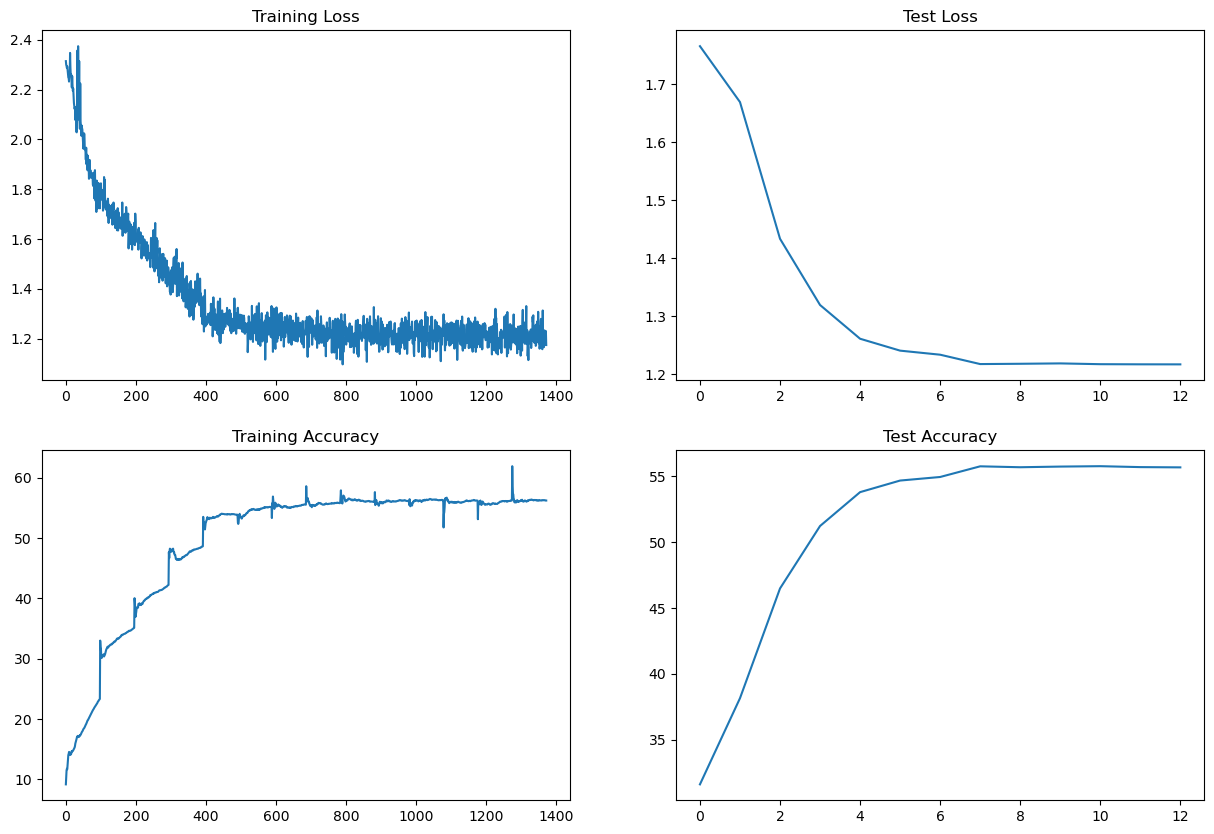

In [ ]:
from model import plot_loss_n_acc
plot_loss_n_acc()

In [ ]:
import pandas as pd
results_df = []
for batch_idx, (data, target) in enumerate(test_loader):
    data, target = data.to(device), target.to(device)
    output = model(data)
    pred_label = output.argmax(dim=1)
    results_df.append(
        pd.DataFrame({"prediction": pred_label.cpu().numpy(),
                      "target": target.cpu().numpy()}))

df = pd.concat(results_df).reset_index(drop=True)

Files already downloaded and verified


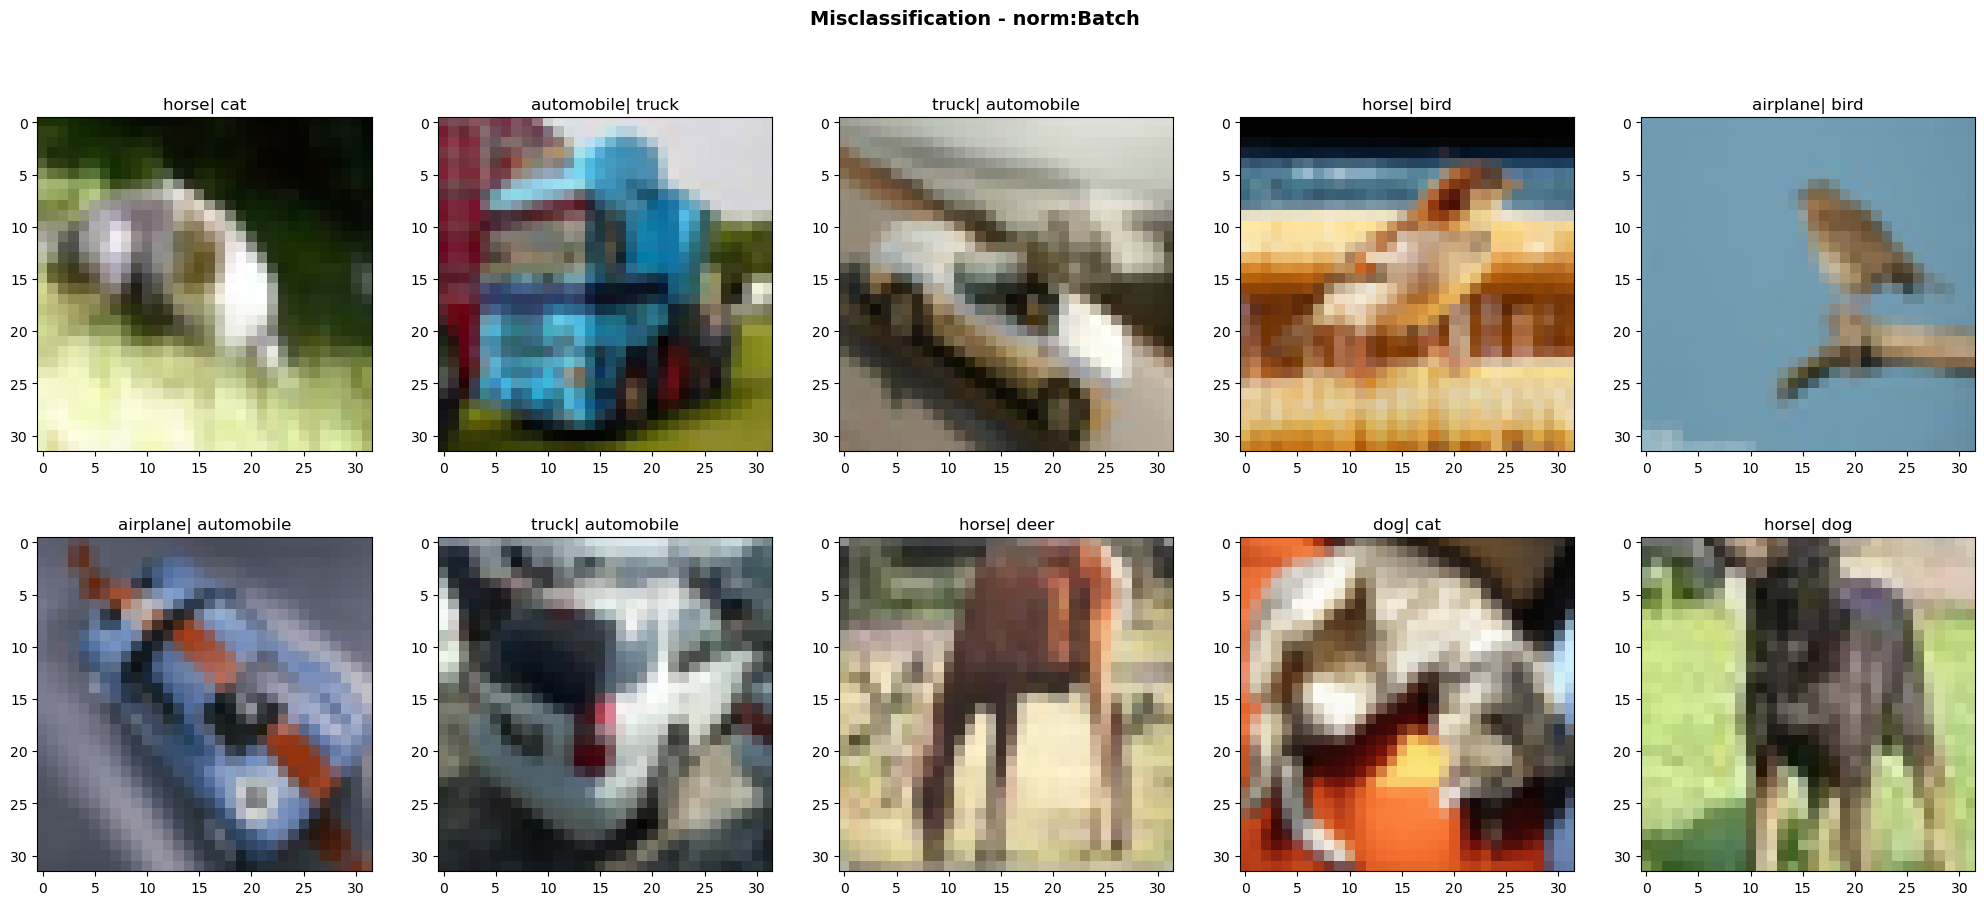

In [ ]:
import matplotlib.pyplot as plt
nrows = 2
ncols = 5
fig, axes = plt.subplots(nrows, ncols, figsize=(25, 10), )
norm='Batch'
fig.suptitle(f"Misclassification - norm:{norm}", weight='bold', size=14)
samples = df.query("prediction != target").sample(10)
axes = axes.ravel()

plot_test_data = datasets.CIFAR10('./data', train=False, download=True,)
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                'dog', 'frog', 'horse', 'ship', 'truck']

for (ix, row), ax in zip(samples.iterrows(), axes):
    img = plot_test_data[ix][0]
    ax.imshow(img, interpolation='nearest')
    ax.set_title(f'{class_labels[row.prediction]}| {class_labels[row.target]}', fontsize=12)